# Projeto de Computação Quântica - CIN0039 - Algoritmo Bernstein-Vazirani


**Grupo:**
* Amanda Arruda (aams2)
* João Vitor Mergulhão (jvlm2)
* Ricardo Bizerra (rblf)

# Enunciado

### **Problema:**
Dado um oráculo que implementa a função $f: \{0,1\}^{n} \rightarrow \{0,1\}$, na qual $f(x)$ é prometido ser o produto escalar entre $x$ e uma string secreta $s\in \{0,1\}^{n}$ mod 2, $f(x)=x\cdot s=x_{1}s_{1}\oplus x_{2}s_{2}\oplus \cdots \oplus x_{n}s_{n}$, encontre $s$.

---
**Entrada:**

Uma string binária secreta 𝑠 ∈ {0,1}^n, representando o parâmetro do oráculo.

Objetivo:

Determinar a string secreta 𝑠 , fazendo uma única chamada ao oráculo quântico.

### **Pseudocódigo:**
1. Definimos n como o número de bits da string secreta s.

2. Criamos um circuito quântico com (n + 1) qubits e n bits clássicos:
   - Qubits 0 até n-1: qubits de entrada (dados)
   - Qubit n: qubit extra auxiliar (ancilla)

3. Inicializamos o qubit auxiliar (n) no estado |-⟩ aplicando:
   a. Porta X
   b. Porta Hadamard (H)

4. Aplicamos porta Hadamard (H) em todos os n qubits de entrada.

5. Aplicamos o oráculo Uf que codifica a string secreta s:
  - Para cada bit da string s igual a '1', aplicar CX entre o qubit de entrada correspondente e o qubit auxiliar.

6. Aplicamos novamente porta Hadamard (H) em todos os n qubits de entrada.

7. Medimos os n qubits de entrada e armazene os resultados nos bits clássicos correspondentes.

8. O resultado da medição é exatamente a string secreta s.

---

### **Diferença de Complexidade: Computação Clássica vs Quântica**

#### Computação Clássica

- Queremos descobrir uma string secreta `s` de `n` bits.
- No modelo clássico, precisamos **consultar a função $f$ para diferentes valores de `x`.
- Para descobrir cada bit de `s`, fazemos \( n \) chamadas ao oráculo, uma para cada posição.

Exemplo:
- Testa \( x = 100 \) → retorna \( s_0 \)
- Testa \( x = 010 \) → retorna \( s_1 \)
- E assim por diante...

**Complexidade clássica:**
\[
\${O}(n)$
\]

#### Computação Quântica

- Utiliza \( n \) qubits de entrada + 1 qubit auxiliar.
- Aplica Hadamard para colocar os qubits de entrada em superposição.
- Executa **uma única chamada** ao oráculo quântico.
- A função \( f(x) = s \cdot x \mod 2 \) é codificada nas fases dos estados quânticos.
- Após aplicar Hadamard novamente, a medição dos qubits de entrada revela diretamente a string `s`.

**Complexidade quântica:**
\[
\${O}(1)$
\]

---

**Artigo:** [Quantum complexity theory - Bernstein, Vazirani - ACM STOC 1993](https://dl.acm.org/doi/pdf/10.1145/167088.167097)

**Circuito:**

![Imagem](https://upload.wikimedia.org/wikipedia/commons/7/79/Bernstein-Vazirani_algorithm_circuit_in_Qiskit.png)

# Importação Qiskit

In [16]:
%pip install qiskit qiskit-aer

In [17]:
print('Versões utilizadas neste projeto'.upper())
print('================================')
print('Biblioteca      Versão'.upper())

from qiskit import __version__ as qiskit_version
print(f'qiskit          {qiskit_version}')

from qiskit_aer import __version__ as qiskit_aer_version
print(f'qiskit-aer      {qiskit_aer_version}')

VERSÕES UTILIZADAS NESTE PROJETO
BIBLIOTECA      VERSÃO
qiskit          2.1.1
qiskit-aer      0.17.1


In [18]:
from qiskit.circuit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram

from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error
from qiskit_aer import AerSimulator

import random

# Implementação

## Funções

In [19]:
def generate_binary_string(n):
    # Define uma seed para que os resultados possam ser replicados
    random.seed(54)

    # Gera número aleatório com n bits
    number = random.getrandbits(n)

    # Converte o número para uma string binária
    binary_string = format(number, '0{n}b')

    return binary_string

In [20]:
def bersteinVaziraniCircuit(n = 0, secret = ''):
  '''
    Cria um circuito quântico para o algoritmo de Bernstein–Vazirani.

    Parâmetros:
    n (int): Número de bits/qubits da string secreta. Ignorado se `secret` for fornecida.
    secret (str): String binária secreta. Se vazia, uma string aleatória de tamanho `n` será gerada.

    Retorna:
      QuantumCircuit: O circuito quântico correspondente ao algoritmo.
  '''

  if len(secret) == 0:
    # Gera string secreta
    secret = generate_binary_string(n)
    print(f"String secreta gerada: {secret}")
  else:
    n = len(secret)

  circuit = QuantumCircuit(n + 1, n)

  # Coloca os qubits de entrada em superposição uniforme
  for i in range(n):
    circuit.h(i)

  circuit.x(n)
  circuit.h(n)

  circuit.barrier()

  # Aplica a função f(x) = s.x(mod 2)
  i = n - 1
  for q in secret:
    if q == '1':
      circuit.cx(i, n)

    i -= 1

  circuit.barrier()

  for i in range(n):
    circuit.h(i)

  # Mede os qubits de entrada
  for i in range(n):
    circuit.measure(i, i)

  return circuit

In [21]:
def simulateCircuit(circuit, n_shots=1000):
  simulator = AerSimulator()
  compiled_circuit = transpile(circuit, simulator)
  result = simulator.run(compiled_circuit, shots=n_shots).result()

  counts = result.get_counts()

  return counts

In [22]:
def simulateNoisyCircuit(circuit, n_shots=1000):
  noise_model = NoiseModel()

  # portas de 1 qubit com 1% de chance de erro
  # portas de 2 qubits com 2% de chance de erro

  error_1q = depolarizing_error(0.01, 1)
  error_2q = depolarizing_error(0.02, 2)

  # Aplicar a certas portas
  noise_model.add_all_qubit_quantum_error(error_1q, ['x', 'h'])
  noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

  simulator = AerSimulator(noise_model=noise_model)

  compiled = transpile(circuit, simulator)
  result = simulator.run(compiled, shots=n_shots).result()
  counts = result.get_counts()

  return counts

## Cria o Circuito

In [23]:
circuit = bersteinVaziraniCircuit(n=8)

String secreta gerada: 11101001


In [24]:
print(circuit)

     ┌───┐      ░                           ░ ┌───┐┌─┐                     
q_0: ┤ H ├──────░───────────────────────■───░─┤ H ├┤M├─────────────────────
     ├───┤      ░                       │   ░ ├───┤└╥┘┌─┐                  
q_1: ┤ H ├──────░───────────────────────┼───░─┤ H ├─╫─┤M├──────────────────
     ├───┤      ░                       │   ░ ├───┤ ║ └╥┘┌─┐               
q_2: ┤ H ├──────░───────────────────────┼───░─┤ H ├─╫──╫─┤M├───────────────
     ├───┤      ░                       │   ░ ├───┤ ║  ║ └╥┘┌─┐            
q_3: ┤ H ├──────░──────────────────■────┼───░─┤ H ├─╫──╫──╫─┤M├────────────
     ├───┤      ░                  │    │   ░ ├───┤ ║  ║  ║ └╥┘┌─┐         
q_4: ┤ H ├──────░──────────────────┼────┼───░─┤ H ├─╫──╫──╫──╫─┤M├─────────
     ├───┤      ░                  │    │   ░ ├───┤ ║  ║  ║  ║ └╥┘┌─┐      
q_5: ┤ H ├──────░─────────────■────┼────┼───░─┤ H ├─╫──╫──╫──╫──╫─┤M├──────
     ├───┤      ░             │    │    │   ░ ├───┤ ║  ║  ║  ║  ║ └╥┘┌─┐   
q_6: ┤ H ├──

## Simula o circuito

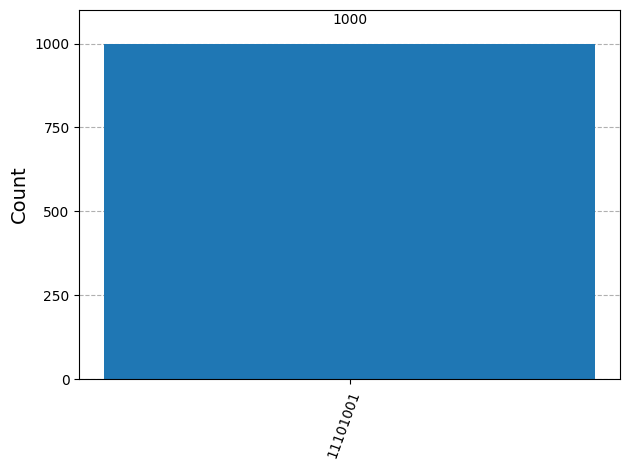

In [25]:
result_counts = simulateCircuit(circuit)

plot_histogram(result_counts)

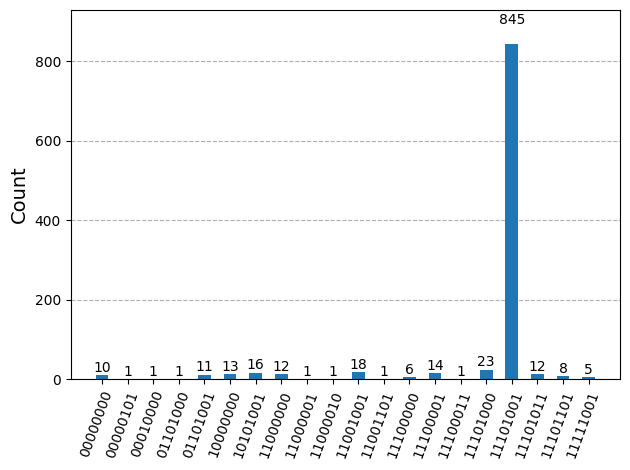

In [26]:
noisy_result_counts = simulateNoisyCircuit(circuit)

plot_histogram(noisy_result_counts)


# Aplicando secret pré-definida ao circuito

## Exemplo 1

In [48]:
circuit_1 = bersteinVaziraniCircuit(secret='1001')

In [49]:
print(circuit_1)

     ┌───┐      ░            ░ ┌───┐┌─┐         
q_0: ┤ H ├──────░────────■───░─┤ H ├┤M├─────────
     ├───┤      ░        │   ░ ├───┤└╥┘┌─┐      
q_1: ┤ H ├──────░────────┼───░─┤ H ├─╫─┤M├──────
     ├───┤      ░        │   ░ ├───┤ ║ └╥┘┌─┐   
q_2: ┤ H ├──────░────────┼───░─┤ H ├─╫──╫─┤M├───
     ├───┤      ░        │   ░ ├───┤ ║  ║ └╥┘┌─┐
q_3: ┤ H ├──────░───■────┼───░─┤ H ├─╫──╫──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐┌─┴─┐ ░ └───┘ ║  ║  ║ └╥┘
q_4: ┤ X ├┤ H ├─░─┤ X ├┤ X ├─░───────╫──╫──╫──╫─
     └───┘└───┘ ░ └───┘└───┘ ░       ║  ║  ║  ║ 
c: 4/════════════════════════════════╩══╩══╩══╩═
                                     0  1  2  3 


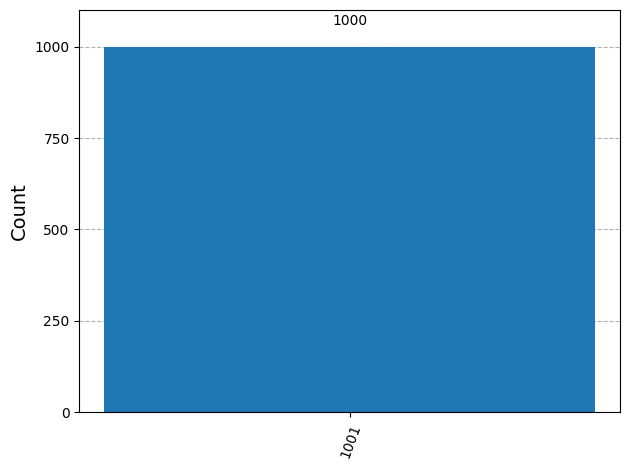

In [50]:
result_counts_1 = simulateCircuit(circuit_1)

plot_histogram(result_counts_1)

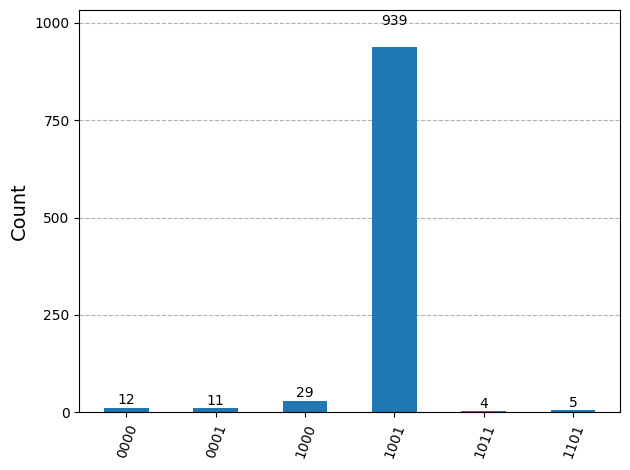

In [51]:
noisy_result_counts_1 = simulateNoisyCircuit(circuit_1)

plot_histogram(noisy_result_counts_1)

## Exemplo 2

In [52]:
circuit_2 = bersteinVaziraniCircuit(secret='1110001')

In [53]:
print(circuit_2)

     ┌───┐      ░                      ░ ┌───┐┌─┐                  
q_0: ┤ H ├──────░──────────────────■───░─┤ H ├┤M├──────────────────
     ├───┤      ░                  │   ░ ├───┤└╥┘┌─┐               
q_1: ┤ H ├──────░──────────────────┼───░─┤ H ├─╫─┤M├───────────────
     ├───┤      ░                  │   ░ ├───┤ ║ └╥┘┌─┐            
q_2: ┤ H ├──────░──────────────────┼───░─┤ H ├─╫──╫─┤M├────────────
     ├───┤      ░                  │   ░ ├───┤ ║  ║ └╥┘┌─┐         
q_3: ┤ H ├──────░──────────────────┼───░─┤ H ├─╫──╫──╫─┤M├─────────
     ├───┤      ░                  │   ░ ├───┤ ║  ║  ║ └╥┘┌─┐      
q_4: ┤ H ├──────░─────────────■────┼───░─┤ H ├─╫──╫──╫──╫─┤M├──────
     ├───┤      ░             │    │   ░ ├───┤ ║  ║  ║  ║ └╥┘┌─┐   
q_5: ┤ H ├──────░────────■────┼────┼───░─┤ H ├─╫──╫──╫──╫──╫─┤M├───
     ├───┤      ░        │    │    │   ░ ├───┤ ║  ║  ║  ║  ║ └╥┘┌─┐
q_6: ┤ H ├──────░───■────┼────┼────┼───░─┤ H ├─╫──╫──╫──╫──╫──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘ ║

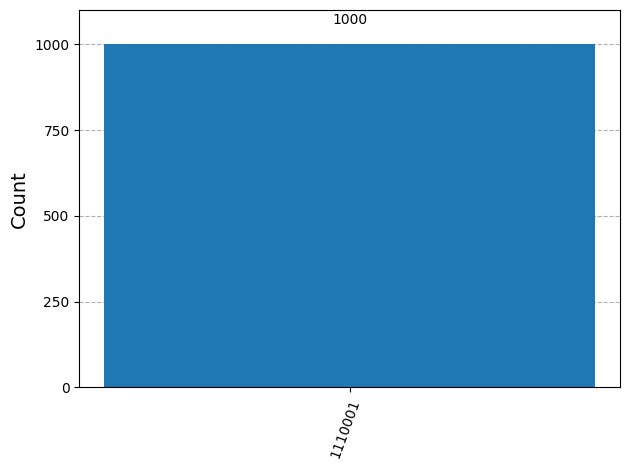

In [54]:
result_counts_2 = simulateCircuit(circuit_2)

plot_histogram(result_counts_2)

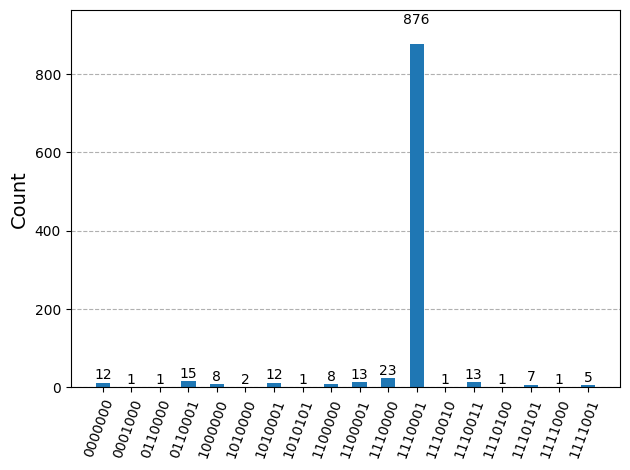

In [55]:
noisy_result_counts_2 = simulateNoisyCircuit(circuit_2)

plot_histogram(noisy_result_counts_2)